In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import cvxpy

import os
import imageio
import random
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal 
import matplotlib.patches as patch
from scipy import signal

In [3]:
#PARAMETROEN DEFINIZIOA
animation=True

M = 0.5;
m = 0.2;
b = 0.1;
I = 0.006;
g = 9.8;
l = 2.0;
l_bar=l
T=30 
nx = 4   # number of state
nu = 1   # number of input
T = 30  # Horizon length

p = I*(M+m)+M*m*l**2


A = np. array([
    [0, 1, 0, 0],
    [0, -(I+m*(l**2)*b)/p,  ((m**2)*g*(l**2))/p,   0],
    [0,  0,  0, 1],
    [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]])

B =np.array([
    [0],
    [(I+m*l**2)/p],
    [0],
    [m*l/p]])

C=np.array([
    [1,0,0,0],
    [0,0,1,0]])

D=np.array([
    [0],
    [0]])

#sys_ss =control.ss(A,B,C,D)
#Ts=0.01 #lagintze peridoa 
#sys_d = control.c2d(sys_ss,Ts,'zoh')
#print(sys_d)

#A = sys_d.A
#B = sys_d.B
#C = sys_d.C
#D = sys_d.D

print(A)
print(B)

delta_t=0.1
A = np.eye(nx) + delta_t * A
B = delta_t * B

print(A)
print(B)

[[ 0.          1.          0.          0.        ]
 [ 0.         -0.21276596  3.87926769  0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.         -0.09896091  6.78871846  0.        ]]
[[0.        ]
 [1.99406235]
 [0.        ]
 [0.9896091 ]]
[[ 1.          0.1         0.          0.        ]
 [ 0.          0.9787234   0.38792677  0.        ]
 [ 0.          0.          1.          0.1       ]
 [ 0.         -0.00989609  0.67887185  1.        ]]
[[0.        ]
 [0.19940623]
 [0.        ]
 [0.09896091]]


Gure egoera bektorea honakoa izango da: 
$x=(x_1,x_2,x_3,x_4)=(r,theta,r',theta')$



In [4]:
def get_nparray_from_matrix(x):
    return np.array(x).flatten()

def flatten(a):
    return np.array(a).flatten()

In [5]:
def mpc_control(x0,Q,R):

    x = cvxpy.Variable((nx, T + 1))
    u = cvxpy.Variable((nu, T))

    cost = 0.0
    constr = []
    for t in range(T):
        cost += cvxpy.quad_form(x[:, t + 1], Q)
        cost += cvxpy.quad_form(u[:, t], R)
        
        #BALDINTZAK
        
        constr += [x[:, t + 1] == A * x[:, t] + B * u[:, t]]
    constr += [x[:, 0] == x0[:, 0]] #hasierako egoera bete behar da 
    
    #MPC optimizazioa ---> Gure koste funtzioa minimoa izatea 
    prob = cvxpy.Problem(cvxpy.Minimize(cost), constr)

    start = time.time()
    prob.solve(verbose=False)
    elapsed_time = time.time() - start

    if prob.status == cvxpy.OPTIMAL:
        ox = get_nparray_from_matrix(x.value[0, :]) #r-ren balioa
        dx = get_nparray_from_matrix(x.value[1, :]) #r'-ren balioa 
        theta = get_nparray_from_matrix(x.value[2, :]) #angelua 
        dtheta = get_nparray_from_matrix(x.value[3, :]) #angeluaren deribatua 

        ou = get_nparray_from_matrix(u.value[0, :]) #kontrol seinalea 

    return ox, dx, theta, dtheta, ou

In [6]:
P=np.array([-0.1,-0.2,-0.3,-0.4])
fsf2 = signal.place_poles(A.transpose(), C.transpose(), P)
Kobs=fsf2.gain_matrix
Kobs=Kobs.transpose()
print("Kobs", Kobs)

Kobs [[ 2.49421367  0.097098  ]
 [15.21284462  1.5809059 ]
 [ 0.09062146  2.48450974]
 [ 1.00976132 16.0257346 ]]


In [7]:
def simulation(x,xobs, u,Kobs): #xberria kalkulatzeko funtzioa 
    #KONTUZ
    uu=+np.dot(Kobs,(np.dot(C,x)-np.dot(C,xobs)))
    xobs=np.dot(A,xobs) + np.dot(B,u)+uu
    x = np.dot(A,x) + np.dot(B,u)    
    return x,xobs

In [8]:
def simulation1(x,u):
    x = np.dot(A,x) + np.dot(B,u)    
    return x    

In [9]:
def show_cart(xt, theta): #Dagokion posizioan irudikatzen dugu karritoa 
    cart_w = 1.0
    cart_h = 0.5
    radius = 0.1

    cx = np.matrix([-cart_w / 2.0, cart_w / 2.0, cart_w /
                    2.0, -cart_w / 2.0, -cart_w / 2.0])
    cy = np.matrix([0.0, 0.0, cart_h, cart_h, 0.0])
    cy += radius * 2.0

    cx = cx + xt

    bx = np.matrix([0.0, l_bar * math.sin(-theta)])
    bx += xt
    by = np.matrix([cart_h, l_bar * math.cos(-theta) + cart_h])
    by += radius * 2.0

    angles = np.arange(0.0, math.pi * 2.0, math.radians(3.0))
    ox = [radius * math.cos(a) for a in angles]
    oy = [radius * math.sin(a) for a in angles]

    rwx = np.copy(ox) + cart_w / 4.0 + xt
    rwy = np.copy(oy) + radius
    lwx = np.copy(ox) - cart_w / 4.0 + xt
    lwy = np.copy(oy) + radius

    wx = np.copy(ox) + float(bx[0, -1])
    wy = np.copy(oy) + float(by[0, -1])

    plt.plot(flatten(cx), flatten(cy), "-b")
    plt.plot(flatten(bx), flatten(by), "-k")
    plt.plot(flatten(rwx), flatten(rwy), "-k")
    plt.plot(flatten(lwx), flatten(lwy), "-k")
    plt.plot(flatten(wx), flatten(wy), "-k")
    plt.title("x:" + str(round(xt, 2)) + ",theta:" +
              str(round(math.degrees(theta), 2)))

    plt.axis("equal")


[-2.0530791] [0.]
[-5.88961991] [2.15637324]
[-0.40749443] [0.33]
[-2.31968304] [0.79306214]
-24.76298412140295 9.106223200872236
Kobs [[ 2.03071959e+00  9.61397297e-03]
 [ 1.00938928e+01  4.84424381e-01]
 [ 9.13902180e-05  2.04800448e+00]
 [-9.85899592e-02  1.11629665e+01]]
[-3.10664578] [0.46129441]
[-24.87233462] [7.41514493]
[-1.02839461] [0.39261694]
[-11.73694757] [3.15803262]
-127.15677360090966 88.42990769341192
Kobs [[ 3.66161678  0.07369462]
 [33.06821324  1.74787242]
 [ 0.06558687  3.66710663]
 [ 1.04667947 34.22429821]]
[-7.34720083] [5.29552572]
[-105.08937915] [115.79181279]
[-3.1954033] [2.89861902]
[-53.50177261] [57.59400532]
-1089.1231880510732 1086.9863973696065


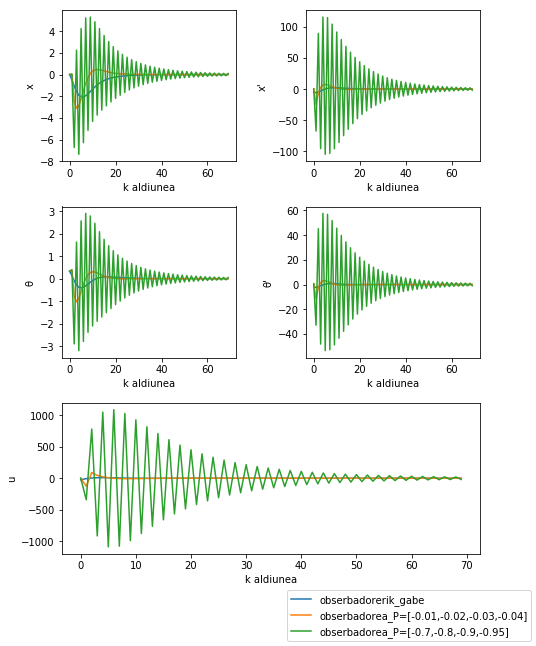

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
#Hasierako egoera definituko dugu: 
fig = plt.figure(figsize=(7.5,10.))
grid= plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
#fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6),);# sharex=True, sharey=True,;
#ax0, ax1, ax2, ax3 = axes.flat

ax0=plt.subplot(grid[0, 0])
ax1=plt.subplot(grid[0, 1:])
ax2=plt.subplot(grid[1, 0])
ax3=plt.subplot(grid[1, 1]);
ax4=plt.subplot(grid[2,:]);

ax0.set_xlabel('k aldiunea');
ax0.set_ylabel('x');

ax1.set_xlabel('k aldiunea');
ax1.set_ylabel("x'");

ax2.set_xlabel('k aldiunea');
ax2.set_ylabel(u"\u03B8");

ax3.set_xlabel('k aldiunea');
ax3.set_ylabel(u"\u03B8""'");

ax4.set_xlabel('k aldiunea');
ax4.set_ylabel("u");

Q = np.diag([100, 0.0, 1, 0.0])
R = np.diag([1])

#----------------------------------------------------------------
kont=5
s="obserbadorerik_gabe"


x0 = np.array([
    [0.0],
    [0.0],
    [0.3],
    [0.3]
    ])

x = np.copy(x0)
    
N=70
u_gorde=[]
x_gorde=[]
dx_gorde=[]
theta_gorde=[]
dtheta_gorde=[]
k=[]
    
for i in range(N):
    figure = plt.figure()
    ox, dx, otheta, dtheta, ou = mpc_control(x,Q,R)
    u = ou[0] #Gordetzen dugu inplementatuko dugun kontrol seinalea
    u_gorde.append(u)

    k.append(i)
    x= simulation1(x,u) #Gure xberria kalkulatzen dugu 
        
    x_gorde.append(x[0])
    dx_gorde.append(x[1])
    theta_gorde.append(x[2])
    dtheta_gorde.append(x[3])
    if animation:
        px = float(x[0]) #x posizioa
        theta = float(x[2]) #theta angelua 
        show_cart(px, theta) #posizioan karritoa irudikatu 
        plt.xlim([-5.0, 2.0]) #x-ren ardatzaren muturrak definitu
        plt.ylim([0.0,3])
        
        
        figure.savefig(os.path.join(os.path.expanduser("~"),"Desktop","gif1"+str(kont),str(i)+".png"),format="png"); #irudia gordeko dugu
        plt.clf() #borratu irudi berria sortzeko 

plt.tight_layout();
fig.subplots_adjust(hspace=0.4, wspace=0.4);
ax0.plot(k,x_gorde)
ax1.plot(k,dx_gorde)
ax2.plot(k,theta_gorde)
ax3.plot(k,dtheta_gorde)
ax4.plot(k,u_gorde,label=s)
    
print(min(x_gorde), max(x_gorde))
print(min(dx_gorde), max(dx_gorde))
print(min(theta_gorde), max(theta_gorde))
print(min(dtheta_gorde), max(dtheta_gorde))
print(min(u_gorde), max(u_gorde))
    
main =os.path.join(os.path.expanduser("~"),"Desktop","gif1"+str(kont))
images = list() #lista batean irudi desberdinak gordetzen ditugu 
for i in range(N):
    images.append(imageio.imread(os.path.join(main,str(i)+".png")))
imageio.mimsave(os.path.join(main,"prueba1.gif"), images,duration=0.1) 

#----------------------------------------------------------------------------------------

s="obserbadorea_P=[-0.01,-0.02,-0.03,-0.04]"
kont=6

P=np.array([-0.01,-0.02,-0.03,-0.04])
fsf2 = signal.place_poles(A.transpose(), C.transpose(), P)
Kobs=fsf2.gain_matrix
Kobs=Kobs.transpose()
print("Kobs", Kobs)

x0 = np.array([
    [0.0],
    [0.0],
    [0.3],
    [0.3]
    ])

xobs = np.array([
    [0.1],
    [0.1],
    [0.0],
    [0.0]
    ])

x = np.copy(x0)
    
N=70
u_gorde=[]
x_gorde=[]
dx_gorde=[]
theta_gorde=[]
dtheta_gorde=[]
k=[]
    
for i in range(N):
    figure = plt.figure()
    ox, dx, otheta, dtheta, ou = mpc_control(xobs,Q,R)
    u = ou[0] #Gordetzen dugu inplementatuko dugun kontrol seinalea
    u_gorde.append(u)

    k.append(i)
    x,xobs = simulation(x,xobs,u,Kobs) #Gure xberria kalkulatzen dugu 
        
    x_gorde.append(x[0])
    dx_gorde.append(x[1])
    theta_gorde.append(x[2])
    dtheta_gorde.append(x[3])
    if animation:
        px = float(x[0]) #x posizioa
        theta = float(x[2]) #theta angelua 
        show_cart(px, theta) #posizioan karritoa irudikatu 
        plt.xlim([-5.0, 2.0]) #x-ren ardatzaren muturrak definitu
        plt.ylim([0.0,3])
        
        
        figure.savefig(os.path.join(os.path.expanduser("~"),"Desktop","gif1"+str(kont),str(i)+".png"),format="png"); #irudia gordeko dugu
        plt.clf() #borratu irudi berria sortzeko 

plt.tight_layout();
fig.subplots_adjust(hspace=0.4, wspace=0.4);
ax0.plot(k,x_gorde)
ax1.plot(k,dx_gorde)
ax2.plot(k,theta_gorde)
ax3.plot(k,dtheta_gorde)
ax4.plot(k,u_gorde,label=s)
    
print(min(x_gorde), max(x_gorde))
print(min(dx_gorde), max(dx_gorde))
print(min(theta_gorde), max(theta_gorde))
print(min(dtheta_gorde), max(dtheta_gorde))
print(min(u_gorde), max(u_gorde))
    
main =os.path.join(os.path.expanduser("~"),"Desktop","gif1"+str(kont))
images = list() #lista batean irudi desberdinak gordetzen ditugu 
for i in range(N):
    images.append(imageio.imread(os.path.join(main,str(i)+".png")))
imageio.mimsave(os.path.join(main,"prueba1.gif"), images,duration=0.1)


#----------------------------------------------------------------
s="obserbadorea_P=[-0.7,-0.8,-0.9,-0.95]"
kont=7
P=np.array([-0.7,-0.8,-0.9,-0.95])
fsf2 = signal.place_poles(A.transpose(), C.transpose(), P)
Kobs=fsf2.gain_matrix
Kobs=Kobs.transpose()
print("Kobs", Kobs)

x0 = np.array([
    [0.0],
    [0.0],
    [0.3],
    [0.3]
    ])

xobs = np.array([
    [0.1],
    [0.1],
    [0.0],
    [0.0]
    ])

x = np.copy(x0)
    
N=70
u_gorde=[]
x_gorde=[]
dx_gorde=[]
theta_gorde=[]
dtheta_gorde=[]
k=[]
    
for i in range(N):
    figure = plt.figure()
    ox, dx, otheta, dtheta, ou = mpc_control(xobs,Q,R)
    u = ou[0] #Gordetzen dugu inplementatuko dugun kontrol seinalea
    u_gorde.append(u)

    k.append(i)
    x,xobs = simulation(x,xobs,u,Kobs) #Gure xberria kalkulatzen dugu 
        
    x_gorde.append(x[0])
    dx_gorde.append(x[1])
    theta_gorde.append(x[2])
    dtheta_gorde.append(x[3])
    if animation:
        px = float(x[0]) #x posizioa
        theta = float(x[2]) #theta angelua 
        show_cart(px, theta) #posizioan karritoa irudikatu 
        plt.xlim([-5.0, 2.0]) #x-ren ardatzaren muturrak definitu
        plt.ylim([0.0,3])
        
        
        figure.savefig(os.path.join(os.path.expanduser("~"),"Desktop","gif1"+str(kont),str(i)+".png"),format="png"); #irudia gordeko dugu
        plt.clf() #borratu irudi berria sortzeko 

plt.tight_layout();
fig.subplots_adjust(hspace=0.4, wspace=0.4);
ax0.plot(k,x_gorde)
ax1.plot(k,dx_gorde)
ax2.plot(k,theta_gorde)
ax3.plot(k,dtheta_gorde)
ax4.plot(k,u_gorde,label=s)
    
print(min(x_gorde), max(x_gorde))
print(min(dx_gorde), max(dx_gorde))
print(min(theta_gorde), max(theta_gorde))
print(min(dtheta_gorde), max(dtheta_gorde))
print(min(u_gorde), max(u_gorde))
    
main =os.path.join(os.path.expanduser("~"),"Desktop","gif1"+str(kont))
images = list() #lista batean irudi desberdinak gordetzen ditugu 
for i in range(N):
    images.append(imageio.imread(os.path.join(main,str(i)+".png")))
imageio.mimsave(os.path.join(main,"prueba1.gif"), images,duration=0.1)

                                              
fig.legend(loc="lower right")
fig.savefig(os.path.join(os.path.expanduser("~"),"Desktop","gif1","magnitudeak_2.png"),format="png",dpi = 150);

